# AUC of LR, RF, KN, DT, NN using old features versus using new features

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to train new models with new features.

## Suggested changes:

- Do train-test split on SiteID, not observations.  That is, all observations made at the same site go either in the train or test dataset.  This helps the classifier figure out the decision boundary for rainfall (observations made a the the same site, with same slope and KF, but different precipitation and different response).
- Use less features. I have tested the logistic regression with the features in `use_feats`.  This improves the scores.
- In order to plot the ROC curve, predict the debris flow probability (using `predict_proba`), not a boolean.  The ROC can only be computed from probabilities.

In [1]:
# %pip install openpyxl==3.1.2

In [2]:
# %pip install torch==1.13.1

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [3]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os

# # visualization libraries
from matplotlib import pyplot as plt
# plt.style.use('bmh')
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

#import torch
#import torch.nn as nn
#import torch.optim as optim

In [4]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc

In [6]:
#torch.cuda.is_available()

In [8]:
#torch.cuda.device_count()

In [10]:
#torch.device('cuda')

## Read in and Examine Staley Raw Data <a id="EDA">

## Explore by Data Types
- aggregate peak rainfall feature to three different time amounts
    - 15 min
    - 30 min
    - 60 min

### Data with old features

In [11]:
pd.set_option("max_colwidth", None)

In [13]:
xl=pd.ExcelFile("ofr20161106_appx-1.xlsx")
desc=xl.parse(xl.sheet_names[0])
modelData=xl.parse(xl.sheet_names[1])

In [62]:
usecols=["Acc015_mm",
         "PropHM23",
         "dNBR/1000",
         "KF",
         "Response",
         "Database"]

usecols = usecols + ["Database"]

In [15]:
cdata=modelData[usecols].copy()
cdata=cdata.dropna()
len(cdata)


1243

In [16]:
cdata.shape

(1243, 6)

In [63]:
#computing input data just as in Staley'16

cdata["PropHM23_x_i15"] = cdata["PropHM23"] * cdata["Acc015_mm"]
cdata["dNBR_x_i15"] = cdata["dNBR/1000"] * cdata["Acc015_mm"]
cdata["KF_x_i15"] = cdata["KF"] * cdata["Acc015_mm"]

In [69]:
usecols2=["PropHM23_x_i15","dNBR_x_i15", "KF_x_i15"]

In [66]:
cdata

,Acc015_mm,PropHM23,dNBR/1000,KF,Response,Database,PropHM23_x_i15,dNBR_x_i15,KF_x_i15
0,0.80,0.217933,0.297853,0.250000,0,Training,0.174346,0.238282,0.200000
1,0.80,0.061249,0.224896,0.250000,0,Training,0.048999,0.179916,0.200000
2,0.80,0.042968,0.065537,0.248541,0,Training,0.034374,0.052430,0.198832
3,0.40,0.092164,0.141711,0.250000,0,Training,0.036866,0.056684,0.100000
4,0.40,0.058353,0.210158,0.250000,0,Training,0.023341,0.084063,0.100000
...,...,...,...,...,...,...,...,...,...
1545,3.50,0.009801,0.187053,0.000000,0,Test,0.034302,0.654684,0.000000
1546,15.75,0.001571,0.500223,0.000000,0,Test,0.024740,7.878512,0.000000
1547,7.25,0.001571,0.500223,0.000000,0,Test,0.011388,3.626616,0.000000
1548,6.25,0.001571,0.500223,0.000000,0,Test,0.009817,3.126394,0.000000


In [67]:
# random split training and test data

feat_data_1 = cdata[usecols2]
target_data_1 = cdata["Response"]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(feat_data_1, 
                                                    target_data_1,
                                                    test_size=.34, # corresponds to staley proportion
                                                    random_state=seed
                                                   )

Reproducing Staley's train-test split:

In [81]:
trainsites = cdata["Database"] == "Training"
X_train_1 = cdata.loc[trainsites,usecols2]
y_train_1 = cdata.loc[trainsites,"Response"]

testsites = cdata["Database"] == "Test"
X_test_1 = cdata.loc[testsites,usecols2]
y_test_1 = cdata.loc[testsites,"Response"]

X_test_1.shape, y_test_1.shape

((428, 3), (428,))

### Data with new features

In [21]:
df = modelDataI=gpd.read_parquet("staley16_observations_catchment_fuelpars_rocktype_randn_v3.parquet")
print('raw data -',df.shape)

df=df.dropna()
print('after nulls removed -',df.shape)

#store clean data to file, this will be used as input to model
df.to_csv("ST16-observations-new-features-v3-na-omit.csv", index=False)

raw data - (1550, 44)
after nulls removed - (1089, 44)


In [22]:
# try with one peak* feature and acc* feature 
features = [
    'peak_i15_mmh',
    'peak_i30_mmh', 
    'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf', 
    'acc015_mm', 
    'acc030_mm', 
    'acc060_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL', 
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated', 
    # 'dom', # need to encode
    # 'domrt', # need to encode
]

features_15 = [
    'peak_i15_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf', 
    'acc015_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL',
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated',
    # 'dom', # need to encode
    # 'domrt', # need to encode
]

features_30 = [
    'peak_i30_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf',
    'acc030_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL', 
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated', 
    # 'dom', # need to encode
    # 'domrt', # need to encode
]

features_60 = [
    'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf',
    'acc060_mm', 
    'NB', 
    'GR', 
    'GS', 
    'SH', 
    'TU', 
    'TL', 
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'Igneous', 
    'Metamorphic', 
    'Sedimentary', 
    'Unconsolidated',
    # 'dom', # need to encode
    # 'domrt', # need to encode
]


y = df['response']

In [23]:
df.shape

(1089, 44)

In [108]:
df["SiteID"].sample(n=2)

405     194
1473    673
Name: SiteID, dtype: int64

In [89]:
trainsites,testsites = train_test_split(df["SiteID"].unique(), test_size=0.34)
len(testsites), len(trainsites)

(205, 397)

In [114]:
# random split training and test data
"""
feat_data_2 = df[features_15]
target_data_2 = df['response']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(feat_data_2, 
                                                    target_data_2,
                                                    test_size=.34,     # corresponds to staley proportion
                                                    random_state=seed
                                                   )
""";

In [109]:
use_feats = [
    "stormdur_h",
    "stormaccum_mm",
    "peak_i15_mmh",
    "contributingarea_km2",
    "prophm23",
    "dnbr1000",
    "kf"]

In [110]:
trainsel = df["SiteID"].apply(lambda x: x in trainsites)
X_train_2 = df.loc[trainsel,use_feats]
y_train_2 = df.loc[trainsel,"response"]

testsel = df["SiteID"].apply(lambda x: x in testsites)
X_test_2 = df.loc[testsel,use_feats]
y_test_2 = df.loc[testsel,"response"]

### score

In [102]:
def get_scores(trues, preds):
    scores=[func(trues, np.round(preds[:,1])) for func in [accuracy_score, jaccard_score, f1_score, roc_auc_score]]
    return scores

def get_scoredf(TrTr, TrPr, TeTr, TePr):
    train_scores=get_scores(TrTr, TrPr)
    test_scores=get_scores(TeTr, TePr)
    
    scoredf=pd.DataFrame({"Training": train_scores, "Test": test_scores}, index=["Accurary", "Jaccard", "F1", "AUC"])
    return scoredf

### 1. Logistic Regression

#### Old features

In [94]:
#LogisticRegression?

In [95]:
#X_train_1, y_train_1

In [111]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_1 = LogisticRegression(random_state=seed, penalty='l2',max_iter=100000).fit(X_train_1, y_train_1)

# predict training data
lr_trainYp_rst_1=clfl_rst_1.predict_proba(X_train_1)

# predict testing data
lr_testYp_rst_1=clfl_rst_1.predict_proba(X_test_1)

# assess model
scoredf_lr_rst_1=get_scoredf(y_train_1, lr_trainYp_rst_1, y_test_1, lr_testYp_rst_1)
scoredf_lr_rst_1

,Training,Test
Accurary,0.833129,0.647196
Jaccard,0.411255,0.386179
F1,0.582822,0.557185
AUC,0.711888,0.703778


#### New features

In [112]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_2 = LogisticRegression(random_state=seed, penalty='l2',max_iter=10000).fit(X_train_2, y_train_2)

# predict training data
lr_trainYp_rst_2=clfl_rst_2.predict_proba(X_train_2)

# predict testing data
lr_testYp_rst_2=clfl_rst_2.predict_proba(X_test_2)

# assess model
scoredf_lr_rst_2=get_scoredf(y_train_2, lr_trainYp_rst_2, y_test_2, lr_testYp_rst_2)
scoredf_lr_rst_2

,Training,Test
Accurary,0.819407,0.792507
Jaccard,0.361905,0.314286
F1,0.531469,0.478261
AUC,0.683500,0.653975


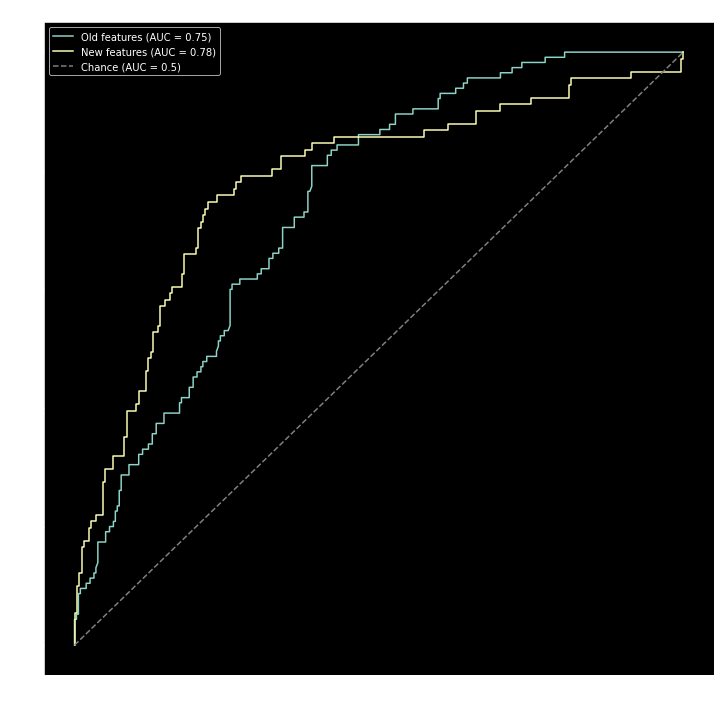

In [106]:
# Calculate ROC curve and AUC

# Old features
lr_fpr_rst_1, lr_tpr_rst_1, _ = roc_curve(y_test_1, lr_testYp_rst_1[:,1], drop_intermediate=False)
lr_auc_rst_1 = auc(lr_fpr_rst_1, lr_tpr_rst_1)

# New features
lr_fpr_rst_2, lr_tpr_rst_2, _ = roc_curve(y_test_2, lr_testYp_rst_2[:,1], drop_intermediate=False)
lr_auc_rst_2 = auc(lr_fpr_rst_2, lr_tpr_rst_2)



# Plot ROC curve
plt.figure(figsize=(12, 12))

# Old features
plt.plot(lr_fpr_rst_1, lr_tpr_rst_1, label=f'Old features (AUC = {lr_auc_rst_1:.2f})')

# New features
plt.plot(lr_fpr_rst_2, lr_tpr_rst_2, label=f'New features (AUC = {lr_auc_rst_2:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

### 2.  Random Forest Classifier

#### Old features

In [116]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_1 = RandomForestClassifier(random_state=seed).fit(X_train_1, y_train_1)

# predict training data
rf_trainYp_rst_1=clfl_rst_1.predict_proba(X_train_1)

# predict testing data
rf_testYp_rst_1=clfl_rst_1.predict_proba(X_test_1)

# assess model
scoredf_rf_rst_1=get_scoredf(y_train_1, rf_trainYp_rst_1, y_test_1, rf_testYp_rst_1)
scoredf_rf_rst_1

,Training,Test
Accurary,1.0,0.591121
Jaccard,1.0,0.347015
F1,1.0,0.515235
AUC,1.0,0.659939


#### New features

In [27]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_2 = RandomForestClassifier(random_state=seed).fit(X_train_2, y_train_2)

# predict training data
rf_trainYp_rst_2=clfl_rst_2.predict(X_train_2)

# predict testing data
rf_testYp_rst_2=clfl_rst_2.predict(X_test_2)

# assess model
scoredf_rf_rst_2=get_scoredf(y_train_2, rf_trainYp_rst_2, y_test_2, rf_testYp_rst_2)
scoredf_rf_rst_2

,Training,Test
Accurary,1.0,0.811321
Jaccard,1.0,0.469697
F1,1.0,0.639175
AUC,1.0,0.743396


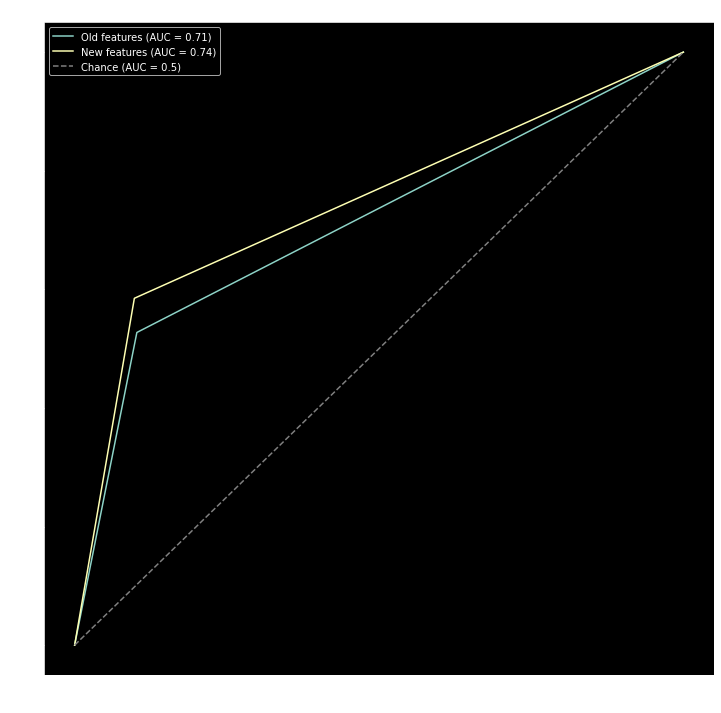

In [28]:
# Calculate ROC curve and AUC

# Old features
rf_fpr_rst_1, rf_tpr_rst_1, _ = roc_curve(y_test_1, rf_testYp_rst_1, drop_intermediate=False)
rf_auc_rst_1 = auc(rf_fpr_rst_1, rf_tpr_rst_1)

# New features
rf_fpr_rst_2, rf_tpr_rst_2, _ = roc_curve(y_test_2, rf_testYp_rst_2, drop_intermediate=False)
rf_auc_rst_2 = auc(rf_fpr_rst_2, rf_tpr_rst_2)



# Plot ROC curve
plt.figure(figsize=(12, 12))

# Old features
plt.plot(rf_fpr_rst_1, rf_tpr_rst_1, label=f'Old features (AUC = {rf_auc_rst_1:.2f})')

# New features
plt.plot(rf_fpr_rst_2, rf_tpr_rst_2, label=f'New features (AUC = {rf_auc_rst_2:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


### 3. KNeighbors Classifier

#### Old features

In [29]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_1 = KNeighborsClassifier().fit(X_train_1, y_train_1)

# predict training data
knn_trainYp_rst_1=clfl_rst_1.predict(X_train_1)

# predict testing data
knn_testYp_rst_1=clfl_rst_1.predict(X_test_1)

# assess model
scoredf_knn_rst_1=get_scoredf(y_train_1, knn_trainYp_rst_1, y_test_1, knn_testYp_rst_1)
scoredf_knn_rst_1

,Training,Test
Accurary,0.837805,0.758865
Jaccard,0.480469,0.341935
F1,0.649077,0.509615
AUC,0.757827,0.669024


#### New features

In [30]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_2 = KNeighborsClassifier().fit(X_train_2, y_train_2)

# predict training data
knn_trainYp_rst_2=clfl_rst_2.predict(X_train_2)

# predict testing data
knn_testYp_rst_2=clfl_rst_2.predict(X_test_2)

# assess model
scoredf_knn_rst_2=get_scoredf(y_train_2, knn_trainYp_rst_2, y_test_2, knn_testYp_rst_2)
scoredf_knn_rst_2

,Training,Test
Accurary,0.857939,0.719677
Jaccard,0.495050,0.262411
F1,0.662252,0.415730
AUC,0.766710,0.608491


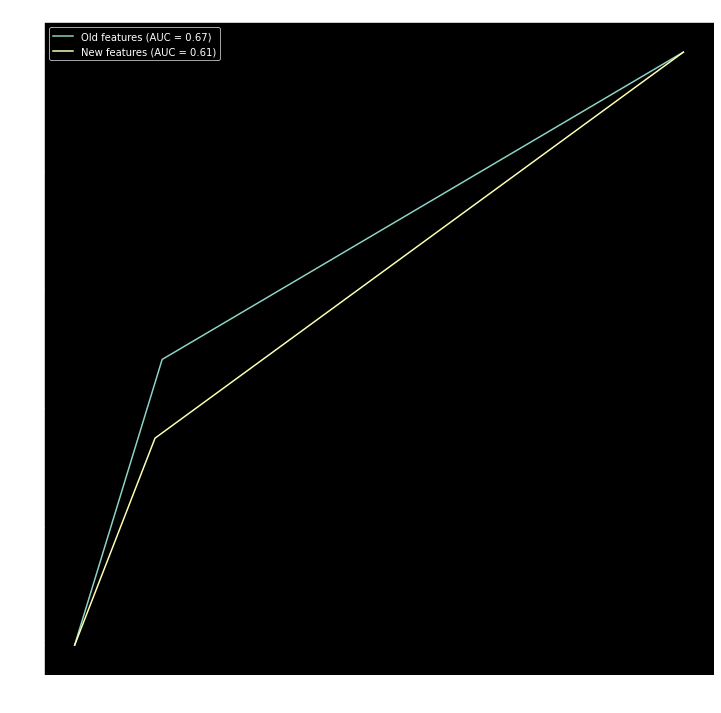

In [31]:
# Calculate ROC curve and AUC

# Old features
knn_fpr_rst_1, knn_tpr_rst_1, _ = roc_curve(y_test_1, knn_testYp_rst_1, drop_intermediate=False)
knn_auc_rst_1 = auc(knn_fpr_rst_1, knn_tpr_rst_1)

# New features
knn_fpr_rst_2, knn_tpr_rst_2, _ = roc_curve(y_test_2, knn_testYp_rst_2, drop_intermediate=False)
knn_auc_rst_2 = auc(knn_fpr_rst_2, knn_tpr_rst_2)


# Plot ROC curve
plt.figure(figsize=(12, 12))

# Old features
plt.plot(knn_fpr_rst_1, knn_tpr_rst_1, label=f'Old features (AUC = {knn_auc_rst_1:.2f})')

# New features
plt.plot(knn_fpr_rst_2, knn_tpr_rst_2, label=f'New features (AUC = {knn_auc_rst_2:.2f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Nearest-Neighbors')
plt.legend()
plt.show()

### 4. Decision Tree Classifier

#### Old features

In [32]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_1 = DecisionTreeClassifier(random_state=seed).fit(X_train_1, y_train_1)

# predict training data
dt_trainYp_rst_1=clfl_rst_1.predict(X_train_1)

# predict testing data
dt_testYp_rst_1=clfl_rst_1.predict(X_test_1)

# assess model
scoredf_dt_rst_1=get_scoredf(y_train_1, dt_trainYp_rst_1, y_test_1, dt_testYp_rst_1)
scoredf_dt_rst_1

,Training,Test
Accurary,0.998780,0.803783
Jaccard,0.995146,0.427586
F1,0.997567,0.599034
AUC,0.997573,0.725908


#### New features

In [33]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_2 = DecisionTreeClassifier(random_state=seed).fit(X_train_2, y_train_2)

# predict training data
dt_trainYp_rst_2=clfl_rst_2.predict(X_train_2)

# predict testing data
dt_testYp_rst_2=clfl_rst_2.predict(X_test_2)

# assess model
scoredf_dt_rst_2=get_scoredf(y_train_2, dt_trainYp_rst_2, y_test_2, dt_testYp_rst_2)
scoredf_dt_rst_2

,Training,Test
Accurary,1.0,0.789757
Jaccard,1.0,0.430657
F1,1.0,0.602041
AUC,1.0,0.719811


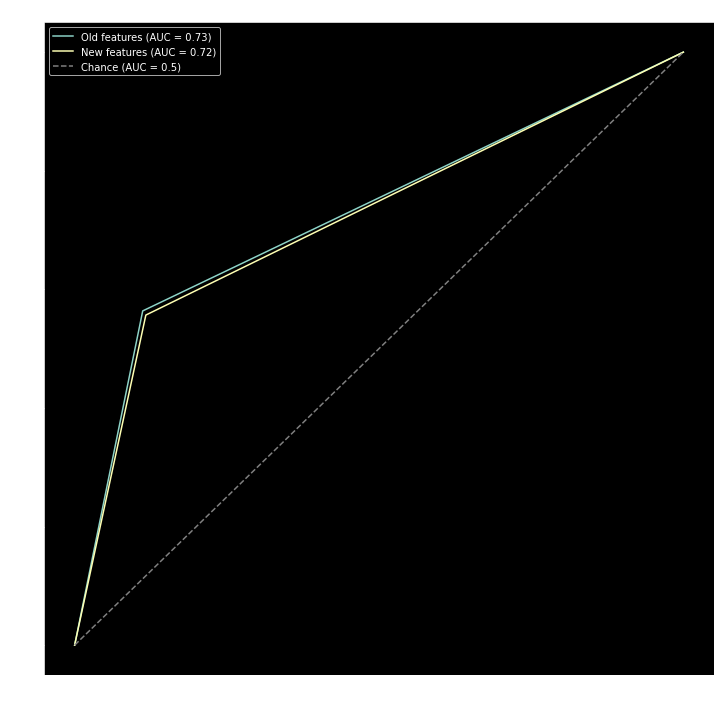

In [34]:
# Calculate ROC curve and AUC


# Old features
dt_fpr_rst_1, dt_tpr_rst_1, _ = roc_curve(y_test_1, dt_testYp_rst_1, drop_intermediate=False)
dt_auc_rst_1 = auc(dt_fpr_rst_1, dt_tpr_rst_1)

# New features
dt_fpr_rst_2, dt_tpr_rst_2, _ = roc_curve(y_test_2, dt_testYp_rst_2, drop_intermediate=False)
dt_auc_rst_2 = auc(dt_fpr_rst_2, dt_tpr_rst_2)


# Plot ROC curve
plt.figure(figsize=(12, 12))

# Old features
plt.plot(dt_fpr_rst_1, dt_tpr_rst_1, label=f'Old features (AUC = {dt_auc_rst_1:.2f})')

# New features
plt.plot(dt_fpr_rst_2, dt_tpr_rst_2, label=f'New features (AUC = {dt_auc_rst_2:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

### 5. Neural Network

#### Old features

In [35]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_1 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=200).fit(X_train_1, y_train_1)

# predict training data
nn_trainYp_rst_1=clfl_rst_1.predict(X_train_1)

# predict testing data
nn_testYp_rst_1=clfl_rst_1.predict(X_test_1)

# assess model
scoredf_nn_rst_1=get_scoredf(y_train_1, nn_trainYp_rst_1, y_test_1, nn_testYp_rst_1)
scoredf_nn_rst_1

/Users/chunxia/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Training,Test
Accurary,0.800000,0.751773
Jaccard,0.426573,0.367470
F1,0.598039,0.537445
AUC,0.730970,0.687816


#### New features

In [36]:
# Random Split train (rst)

# instantiate and fit model on training data
clfl_rst_2 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=200).fit(X_train_2, y_train_2)

# predict training data
nn_trainYp_rst_2=clfl_rst_2.predict(X_train_2)

# predict testing data
nn_testYp_rst_2=clfl_rst_2.predict(X_test_2)

# assess model
scoredf_nn_rst_2=get_scoredf(y_train_2, nn_trainYp_rst_2, y_test_2, nn_testYp_rst_2)
scoredf_nn_rst_2

,Training,Test
Accurary,0.759053,0.735849
Jaccard,0.059783,0.125000
F1,0.112821,0.222222
AUC,0.518193,0.554717


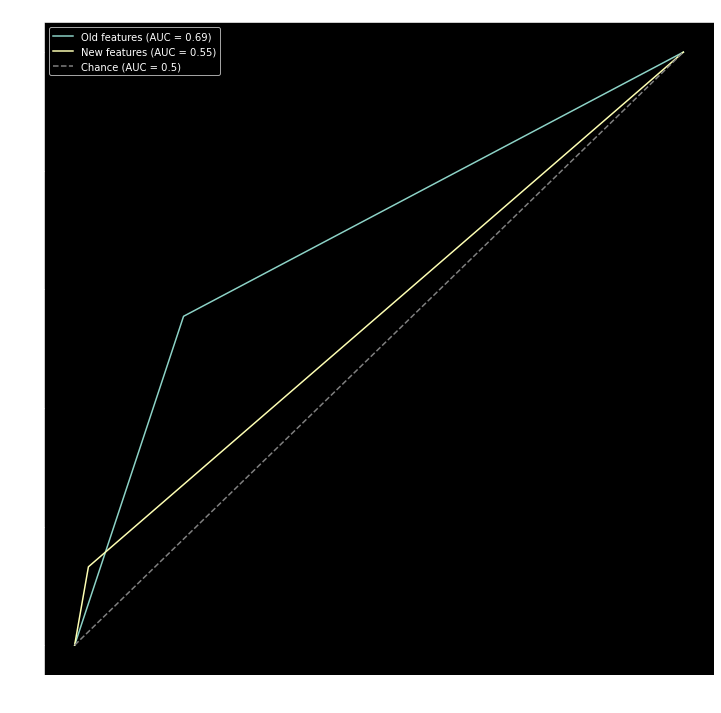

In [37]:
# Calculate ROC curve and AUC

# Old features
nn_fpr_rst_1, nn_tpr_rst_1, _ = roc_curve(y_test_1, nn_testYp_rst_1, drop_intermediate=False)
nn_auc_rst_1 = auc(nn_fpr_rst_1, nn_tpr_rst_1)

# New features
nn_fpr_rst_2, nn_tpr_rst_2, _ = roc_curve(y_test_2, nn_testYp_rst_2, drop_intermediate=False)
nn_auc_rst_2 = auc(nn_fpr_rst_2, nn_tpr_rst_2)


# Plot ROC curve
plt.figure(figsize=(12, 12))

# Old features
plt.plot(nn_fpr_rst_1, nn_tpr_rst_1, label=f'Old features (AUC = {nn_auc_rst_1:.2f})')

# New features
plt.plot(nn_fpr_rst_2, nn_tpr_rst_2, label=f'New features (AUC = {nn_auc_rst_2:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.show()